In [ ]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.stats import norm
import matplotlib.pyplot as plt

### 15.2.7 Bond Pricing in Practice: Duration and Convexity vs. Maturity

In this coding example we detail how to leverage the formulas presented in this chapter, equations (15.5), (15.6), and (15.7), to compute a bond price, as well as its duration and convexity:

In [ ]:
def bond_price_dur_conv(C, P, y, mat, coupon_frequency):
    '''
    C: coupon payment
    P: principal value
    y: yield to maturity
    mat: maturity (in years)
    coupon_frequency: number of coupon payments per year
    '''

    B = 0
    duration_sum = 0
    convexity_sum = 0

    total_payments = coupon_frequency * mat

    for payment in range(1, total_payments+1):

        payment_time = payment/coupon_frequency

        B += C * np.exp(-y * payment_time)
        duration_sum += C * payment_time* np.exp(-y * payment_time)
        convexity_sum += C * payment_time**2 * np.exp(-y * payment_time)

    B += P * np.exp(-y* mat)
    duration_sum += P * mat * np.exp(-y * mat)
    convexity_sum += P * mat**2 * np.exp(-y * mat)

    # convention is to report duration as a positive number
    duration = -(-1/B * duration_sum)
    convexity = 1/B * convexity_sum

    return B, duration, convexity

In [ ]:
def plot_dur_conv_vs_mat(C, P, y, coupon_frequency, mat_lo, mat_hi):
    '''
    C: coupon payment
    P: principal value
    y: yield to maturity
    mat_lo: lower maturity bound (in years)
    mat_hi: upper maturity bound (in years)
    '''

    durations = []
    convexities = []
    maturities = range(mat_lo, mat_hi + 1)

    for mat in maturities:

        B, duration, convexity = bond_price_dur_conv(C, P, y, mat, coupon_frequency)

        durations.append(duration)
        convexities.append(convexity)

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
    ax[0].plot(maturities, durations)
    ax[0].set_xlabel('Maturity')
    ax[0].set_ylabel('Duration')
    ax[0].set_title("Duration vs. Maturity")

    ax[1].plot(maturities, convexities)
    ax[1].set_xlabel('Maturity')
    ax[1].set_ylabel('Convexity')
    ax[1].set_title('Convexity vs. Maturity')

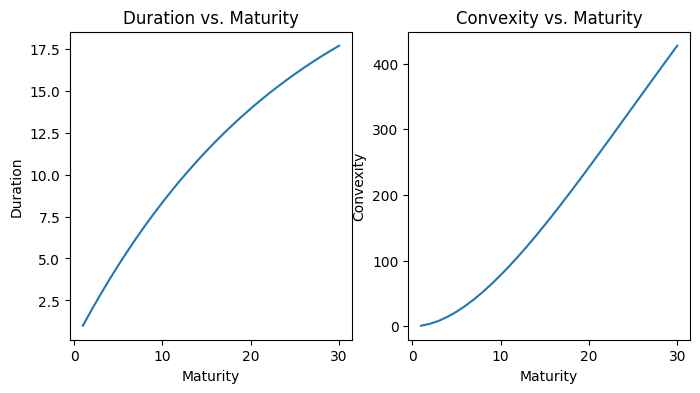

In [ ]:
# example
P = 10000
y = 0.04
coupon_frequency = 2
C = P * y / coupon_frequency
mat_lo = 1
mat_hi = 30

plot_dur_conv_vs_mat(C, P, y, coupon_frequency, mat_lo, mat_hi)

### 15.5.5 Bootstrapping in Practice: US Swap Rates

In this coding example we detail how a bootstrapping yield curve construction algorithm can be implemented in Python for a set of interest rate swaps.

In [ ]:
def cal_integral(start_period, end_period, yield_curve):
    '''
    Helper function - approximate the integral of the yield curve between two periods.
    '''

    s = 0
    for i in range(end_period-start_period+1):
        s += 0.5 * yield_curve[start_period+i]
    return s


def cal_forward_rate(start_period, end_period, yield_curve):
    '''
    Helper function - calculate the forward rates between two periods according to (15.19).
    '''

    if start_period == end_period:
        return 0
    else:
        integral_part = cal_integral(start_period, end_period, yield_curve)
        result = (np.exp(integral_part)-1)*(1/(end_period-start_period))
        return result


def cal_discount_factor(start_period, end_period, yield_curve):
    '''
    Helper function - calculate the discount factor between two periods.
    '''

    integral_part = cal_integral(start_period, end_period, yield_curve)
    return np.exp(-integral_part)


def cal_swap_rate(coupon_frequency, mat, yield_curve):
    '''
    Calculate swap rates according to (15.13).
    coupon_frequency: number of coupon payments per year
    mat: maturity (in years)
    '''

    end_period = int(coupon_frequency * mat)
    s_num = 0
    s_denom = 0
    for i in range(1, end_period):
        s_num += cal_discount_factor(0, i, yield_curve) * cal_forward_rate(i, i+1, yield_curve)
        s_denom += cal_discount_factor(0, i, yield_curve)

    return s_num/s_denom

In [ ]:
def root_finder(x, coupon_frequency, mat, previous_period, target_rate, yield_curve):
    '''
    Calculate the difference between the calibrated swap rate and the target swap rate for optimization purposes.
    coupon_frequency: number of coupon payments per year
    mat: maturity (in years)
    previous_period: number of previous periods before adjustment
    target_rate: target swap rate
    '''

    end_period = int(coupon_frequency * mat)

    for i in range(1+2*previous_period, end_period+1):
        yield_curve[i] = x

    swap_rate = cal_swap_rate(coupon_frequency, mat, yield_curve)
    return swap_rate - target_rate

In [ ]:
# example
rates = [0.07, 0.20, 0.42, 0.78, 1.08, 1.31, 1.84, 1.92]
mats = [1, 2, 3, 5, 7, 10, 20, 30]
yield_curve = np.zeros(61)

previous_period = 0
for k, r in zip(mats, rates):
    optimize.root(root_finder, x0=0.01, args=(k, coupon_frequency, previous_period, r/100, yield_curve))
    previous_period = k

/tmp/ipython-input-1191581513.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yield_curve[i] = x


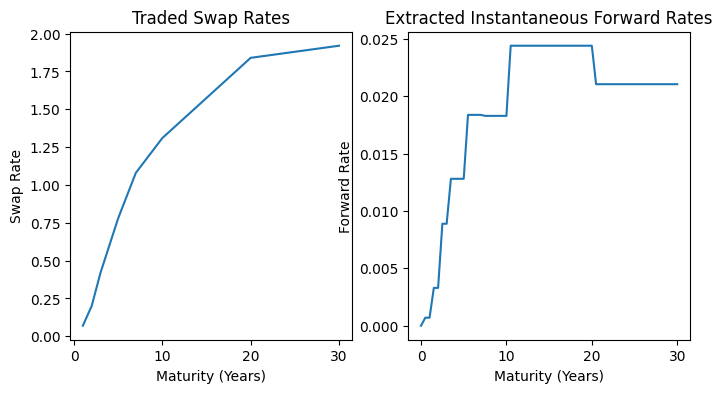

In [ ]:
# visualization
mat_ts = np.arange(0, 61)*0.5

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.title("Traded Swap Rates")
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.plot(mats, rates)

plt.subplot(1, 2, 2)
plt.title("Extracted Instantaneous Forward Rates")
plt.xlabel("Maturity (Years)")
plt.ylabel("Forward Rate")
plt.plot(mat_ts, yield_curve);

### 15.8.2 Caplets/Floorlets via Black's Model

In this coding example we detail how a cap or floor pricing model can be implemented based on Black's model. As we can see in the following sample, the model works by pricing each caplet separately in a for loop which can be done because each caplet has an independent exercise decision.

Note that we will reuse helper functions `cal_forward_rate()` and `cal_discount_factor()` from 15.5.5.

In [ ]:
def price_caplet(sigma, K, delta, rates, T):
    '''
    sigma: interest rate volatility
    K: caplet strike price
    delta: time increment
    rates: yield curve
    T: time to maturity (in years)
    '''

    f_0 = cal_forward_rate(T, T+delta, rates)

    d1 = (np.log(f_0/K) + 0.5*sigma**2*T)/(sigma * np.sqrt(T))
    d2 = (np.log(f_0/K) - 0.5*sigma**2*T)/(sigma * np.sqrt(T))

    cap = delta * cal_discount_factor(0, T+delta, rates) * (f_0 * norm.cdf(d1) - K*norm.cdf(d2))

    return cap


def price_cap(sigma, K, delta, rates, start, length):
    '''
    sigma: interest rate volatility
    K: caplet strike price
    delta: time increment
    rates: yield curve
    start: starting time
    length: total time horizon
    '''

    cap = 0

    for i in range(int(length/delta)):

        t = start + delta*i
        caplet = price_caplet(sigma, K, delta, rates, t)
        cap += caplet

    return cap

In [ ]:
# example
sigma = 0.2
K1 = 0.015
K2 = 0.01
delta = 1
rates = [0.07, 0.20, 0.42, 0.78, 1.08, 1.31, 1.84, 1.92]
T = 1
start = 1
length = 5

print(price_caplet(sigma, K1, delta, rates, T))
print(price_cap(sigma, K2, delta, rates, start, length))

0.2467617574877495
1.6196273155869132


### 15.9.3 Fitting the Volatility Skew with the SABR Model

In this coding example, we show how a SABR model can be leveraged to calibrate a swaption volatility in interest rate markets.  The reader should notice that a separate set of model parameters are calibrated for each expiry, and that, as is standard when calibrating a SABR model, the $\beta$ parameter is fixed and the remaining parameters are optimized for. Also, please note that we use an ATM limiting expression when
$F_0 \approx K$ to avoid the $0/0$ numerical instability in the asymptotic formula. The reader feel free to use multiple methods to approximate the limit as $F_0 \to K$, such as the L'Hopital's rule.

In [ ]:
def asymptotic_normal_vol(F0, K, T, sigma0, alpha, beta, rho):
    '''
    F0: current forward rate
    K: strike price
    T: time to maturity (in years)
    sigma0: initial volatility
    alpha: volatility of volatility
    beta: skewness parameter
    rho: correlation between the forward rate and the volatility
    '''

    Fmid = (F0 + K)/2
    zeta = alpha/(sigma0 * (1-beta)) * (F0 ** (1-beta) - K **(1-beta))
    eps = T*alpha**2
    delta = np.log((np.sqrt(1-2 * rho * zeta + zeta**2) + zeta - rho)/(1-rho))
    gamma1 = beta/Fmid
    gamma2 = beta * (beta -1)/Fmid**2

    partb1 = (2*gamma2 - gamma1**2)/24 * (sigma0 * Fmid ** beta /alpha)**2
    partb2 = rho * gamma1/4 * sigma0 * Fmid **beta/alpha
    partb3 = (2-3 *rho **2)/24
    partb = (1+(partb1 + partb2 + partb3) * eps)

    # safe computation of parta with ATM limit to avoid 0/0
    if abs(delta) < eps:
        parta = sigma0 * (Fmid**beta)
    else:
        parta = alpha * (F0 - K) / delta

    return parta * partb


def rootfind_helper(sabr_params, F0, K_list, T, sigma_list):
    '''
    sabr_params: sigma0, alpha, rho
    F0: current forward rate
    K_list: list of strike prices
    T: time to maturity (in years)
    sigma_list: list of observed volatilities corresponding to each strike price in K_list
    '''

    sigma0, alpha, rho = sabr_params
    beta = 0.5
    MSE = 0

    for i in range(len(K_list)):
        diff = asymptotic_normal_vol(F0, K_list[i], T, sigma0, alpha, beta, rho) - sigma_list[i]
        MSE += diff**2

    return MSE


def calibrate_sabr(F0_list, K_table, T_list, sigma_table):
    '''
    F0_list: list of current forward rates
    K_table: array of strike prices for each maturity time
    T_list: list of maturity times
    sigma_table: array of observed volatilities for each strike price and maturity time
    '''

    init_guess = [0.1, 0.1, -0.1]
    params = np.zeros((len(T_list),3))

    for i,T in enumerate(T_list):
        opt = optimize.minimize(rootfind_helper, init_guess, args = (F0_list[i], K_table[i], T, sigma_table[i]),
                                method = 'SLSQP', bounds = ((0.01,1.5),(0,10),(-0.98,0.98)))
        params[i] = opt.x

    return params

In [ ]:
# example
F0_list = [0.0135, 0.0142, 0.0146, 0.0149, 0.0153, 0.0158]
T_list = [1, 2, 3, 5, 7, 10]
K_list = [0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02]
K_table = [K_list] * 6
sigma_list = [0.145, 0.15, 0.155, 0.16, 0.165, 0.17]
sigma_table = [sigma_list] * 6

calibrate_sabr(F0_list, K_table, T_list, sigma_table)

array([[ 0.3197218 ,  6.21652112,  0.24076929],
       [ 0.54413912,  3.05788438,  0.95649848],
       [ 0.09794341,  7.18702116, -0.08534357],
       [ 0.41727974,  2.33874061,  0.92707765],
       [ 0.4013437 ,  2.01080665,  0.97967281],
       [ 0.36198777,  1.79641528,  0.97945531]])

### 15.10.3 Vasicek
In this coding example we provide a function for simulating from the Vasicek short rate model:

In [ ]:
def sim_Vasicek(r0, kappa, theta, sigma, T, nper):
    '''
    r0: initial short latent rate
    kappa: speed of mean-reversion
    theta: level of mean-reversion
    sigma: short rate volatility
    T: time to maturity (in years)
    nper: number of time steps per year
    '''

    rate_path = np.zeros(T*nper)
    rate_path[0] = r0

    dt = 1/nper
    for i in range(1,T*nper):
        dWt = np.random.normal(0,np.sqrt(1/nper))
        rate_path[i] = rate_path[i-1] + kappa*(theta - rate_path[i-1]) * dt + sigma * dWt

    return rate_path

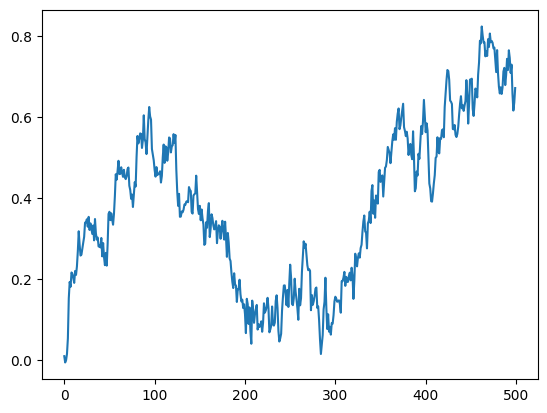

In [ ]:
# example
r0 = 0.01
kappa = 0.25
theta = 0.025
sigma = 0.25
T = 10
nper = 50

rate_path = sim_Vasicek(r0, kappa, theta, sigma, T, nper)

plt.plot(rate_path);